# Test problem 1: Channel flow (Poiseuille flow)

Authors: Anders Logg and Hans Petter Langtangen

Adapted to DOLFINx by: Jørgen S. Dokken

In this section, you will learn how to:
- Solve the Navier-Stokes problem using a splitting scheme
- Visualize functions from higher order Lagrangian spaces

In this section, we will compute the flow between two infinite plates, so-called channel or Poiseuille flow.
As we shall see, this problem has an analytical solution.
Let $H$ be the distance between the plates and  $L$ the length of the channel. There are no body forces.

We may scale the problem first to get rid of seemingly independent physical parameters. The physics of this problem is governed by viscous effects only, in the direction perpendicular to the flow, so a time scale should be based on diffusion across the channel: $t_v=H^2/\nu$. We let $U$, some characteristic inflow velocity, be the velocity scale and $H$ the spatial scale. The pressure scale is taken as the characteristic shear stress, $\mu U/H$, since this is a primary example of shear flow. Inserting $\bar{x}=x/H, \bar{y}=y/H, \bar{z}=z/H, \bar{u}=u/U, \bar{p}=Hp/{\mu U}$, and $\bar{t}=H^2/\nu$ in the equations results in the scaled Navier-Stokes equations (dropping the bars after scaling)
```{math}
:label: ns-scaled
\frac{\partial u}{\partial t}+ \mathrm{Re} u \cdot \nabla u &= -\nabla p + \nabla^2 u,\\
\nabla \cdot u &=0.
```
A detailed derivation for scaling of the Navier-Stokes equation for a large variety of physical situations can be found in {cite}`Langtangen2016scaling` (Chapter 4.2) by Hans Petter Langtangen and Geir K. Pedersen.

Here, $\mathrm{Re}=\rho UH/\mu$ is the Reynolds number. Because of the time and pressure scales, which are different from convection dominated fluid flow, the Reynolds number is associated with the convective term and not the viscosity term.

The exact solution is derived by assuming $u=(u_x(x,y,z),0,0)$ with the $x$-axis pointing along the channel. Since $\nabla \cdot u = 0$, $u$ cannot be dependent on $x$.

The physics of channel flow is also two-dimensional so we can omit the $z$-coordinate (more precisely: $\partial/\partial z = 0$). Inserting $u=(u_x, 0, 0)$ in the (scaled) governing equations gives $u_x''(y)=\frac{\partial p}{\partial x}$.
Differentiating this equation with respect to $x$ shows that
$\frac{\partial^2p}{\partial x^2}=0$ so $\partial p/\partial x$ is a constant here called $-\beta$. This is the driving force of the flow and can be specified as a known parameter in the problem. Integrating $u_x''(x,y)=-\beta$ over the width of the channel, $[0,1]$, and requiring $u=(0,0,0)$ at the channel walls, results in $u_x=\frac{1}{2}\beta y(1-y)$. The characteristic inlet velocity $U$ can be taken as the maximum inflow at $y=0.5$, implying $\beta=8$. The length of the  channel, $L/H$ in the scaled model, has no impact on the result, so for simplicity we just compute on the unit square. Mathematically, the pressure must be prescribed at a point, but since $p$ does not depend on $y$, we can set $p$ to a known value, e.g. zero, along the outlet boundary $x=1$. The result is
$p(x)=8(1-x)$ and $u_x=4y(1-y)$.

The boundary conditions can be set as $p=8$ at $x=0$, $p=0$ at $x=1$ and $u=(0,0,0)$ on the walls $y=0,1$. This defines the pressure drop and should result in unit maximum velocity at the inlet and outlet and a parabolic velocity profile without no further specifications. Note that it is only meaningful to solve the Navier-Stokes equations in 2D or 3D geometries, although the underlying mathematical problem collapses to two $1D$ problems, one for $u_x(y)$ and one for $p(x)$.

The scaled model is not so easy to simulate using a standard Navier-Stokes solver with dimensions. However, one can argue that the convection term is zero, so the Re coefficient in front of this term in the scaled PDEs is not important and can be set to unity. In that case, setting $\rho=\mu=1$ in the original Navier-Stokes equations resembles the scaled model.

For a specific engineering problem one wants to simulate a specific fluid and set corresponding parameters. A general solver is therefore most naturally implemented with dimensions and using the original physical parameters.
However, scaling may greatly simplify numerical simulations.
First of all, it shows that all fluids behave in the  same way; it does not matter whether we have oil, gas, or water flowing between two plates, and it does not matter how fast the flow is (up to some critical value of the Reynolds number where the flow becomes unstable and transitions  to a complicated turbulent flow of totally different nature.)
 This means that one simulation is enough to cover all types of channel flow!
In other applications, scaling shows that it might be necessary to just set the fraction of some parameters (dimensionless numbers) rather than the parameters themselves. This simplifies exploring the input parameter space which is often the purpose of simulation. Frequently, the scaled problem is run by setting some of the input parameters with dimension to fixed values (often unity).

## Implementation

Author: Jørgen S. Dokken

As in the previous example, we load the DOLFINx module, along with the `mpi4py` module, and create the unit square mesh and define the run-time and temporal discretization

In [1]:
from mpi4py import MPI
from petsc4py import PETSc
import numpy as np
import pyvista

from dolfinx.fem import Constant, Function, functionspace, assemble_scalar, dirichletbc, form, locate_dofs_geometrical
from dolfinx.fem.petsc import assemble_matrix, assemble_vector, apply_lifting, create_vector, set_bc
from dolfinx.io import VTXWriter
from dolfinx.mesh import create_unit_square
from dolfinx.plot import vtk_mesh
from basix.ufl import element
from ufl import (FacetNormal, Identity, TestFunction, TrialFunction,
                 div, dot, ds, dx, inner, lhs, nabla_grad, rhs, sym)

mesh = create_unit_square(MPI.COMM_WORLD, 10, 10)
t = 0
T = 10
num_steps = 500
dt = T / num_steps

As opposed to the previous demos, we will create our two function spaces using the `ufl` element definitions as input

In [2]:
v_cg2 = element("Lagrange", mesh.topology.cell_name(), 2, shape=(mesh.geometry.dim, ))
s_cg1 = element("Lagrange", mesh.topology.cell_name(), 1)
V = functionspace(mesh, v_cg2)
Q = functionspace(mesh, s_cg1)

The first space `V` is a vector valued function space for the velocity, while `Q` is a scalar valued function space for pressure. We use piecewise quadratic elements for the velocity and piecewise linear elements for the pressure. When creating the vector finite element, the dimension of the vector element will be set to the geometric dimension of the mesh. One can easily create vector-valued function spaces with other dimensions by replacing `(mesh.geometry.dim, )` with something else, like
```
v_cg  basix.ufl.element("Lagrange", mesh.topology.cell_name(), 2, shape=(10,))
```
or 
```
tensor_element = basix.ufl.element("Lagrange", mesh.topology.cell_name(), 2, shape=(3, 3))
```
or
```
tensor_element = basix.ufl.element("Lagrange", mesh.topology.cell_name(), 2, shape=(3, 2, 4))
```


```{admonition} Stable finite element spaces for the Navier-Stokes equation
It is well-known that certain finite element spaces are not *stable* for the Navier-Stokes equations, or even for the  simpler Stokes equation. The prime example of an unstable pair of finite element spaces is to use first order degree continuous piecewise polynomials for both the velocity and the pressure.
Using an unstable pair of spaces typically results in a solution with *spurious* (unwanted, non-physical) oscillations in the pressure solution. The simple remedy is to use continuous piecewise quadratic elements for the velocity and continuous piecewise linear elements for the pressure. Together, these elements form the so-called *Taylor-Hood* element. Spurious oscillations may occur also for splitting methods if an unstable element pair is used.

Since we have two different function spaces, we need to create two sets of trial and test functions:

In [3]:
u = TrialFunction(V)
v = TestFunction(V)
p = TrialFunction(Q)
q = TestFunction(Q)

As we have seen in [Linear elasticity problem](./linearelasticity_code) we can use Python-functions to create the different Dirichlet conditions. For this problem, we have three Dirichlet condition: First, we will set $u=0$ at the walls of the channel, that is at $y=0$ and $y=1$. In this case, we will use `dolfinx.fem.locate_dofs_geometrical`

In [4]:
def walls(x):
    return np.logical_or(np.isclose(x[1], 0), np.isclose(x[1], 1))

In [5]:
wall_dofs = locate_dofs_geometrical(V, walls)
u_noslip = np.array((0,) * mesh.geometry.dim, dtype=PETSc.ScalarType)
bc_noslip = dirichletbc(u_noslip, wall_dofs, V)

Second, we will set $p=8$ at the inflow ($x=0$)

In [6]:
def inflow(x):
    return np.isclose(x[0], 0)

In [7]:
inflow_dofs = locate_dofs_geometrical(Q, inflow)
bc_inflow = dirichletbc(PETSc.ScalarType(8), inflow_dofs, Q)

And finally, $p=0$ at the outflow ($x=1$). This will result in a pressure gradient that will accelerate the flow from the initial state with zero velocity. At the end, we collect the boundary conditions for the velocity and pressure in Python lists so we can easily access them in the following computation.

In [8]:
def outflow(x):
    return np.isclose(x[0], 1)

In [9]:
outflow_dofs = locate_dofs_geometrical(Q, outflow)
bc_outflow = dirichletbc(PETSc.ScalarType(0), outflow_dofs, Q)
bcu = [bc_noslip]
bcp = [bc_inflow, bc_outflow]

We now move on to the  definition of the three variational forms, one for each step in the IPCS scheme. Let us look at the definition of the first variational problem and the relevant parameters.

In [10]:
u_n = Function(V)
u_n.name = "u_n"
U = 0.5 * (u_n + u)
n = FacetNormal(mesh)
f = Constant(mesh, PETSc.ScalarType((0, 0)))
k = Constant(mesh, PETSc.ScalarType(dt))
mu = Constant(mesh, PETSc.ScalarType(1))
rho = Constant(mesh, PETSc.ScalarType(1))

```{admonition} Usage of "dolfinx.Constant"
Note that we have wrapped several parameters as constants. This is to reduce the compilation-time of the variational formulations. By wrapping them as a constant, we can change the variable
```
The next step is to set up the variational form of the first step.
As the variational problem contains a mix of known and unknown quantities, we will use the following naming convention: `u` (mathematically $u^{n+1}$) is known as a trial function in the variational form. `u_` is the most recently computed approximation ($u^{n+1}$ available as a `Function` object), `u_n` is $u^n$, and the same convention goes for `p,p_` ($p^{n+1}$) and `p_n` (p^n).

In [11]:
# Define strain-rate tensor
def epsilon(u):
    return sym(nabla_grad(u))

# Define stress tensor


def sigma(u, p):
    return 2 * mu * epsilon(u) - p * Identity(len(u))


# Define the variational problem for the first step
p_n = Function(Q)
p_n.name = "p_n"
F1 = rho * dot((u - u_n) / k, v) * dx
F1 += rho * dot(dot(u_n, nabla_grad(u_n)), v) * dx
F1 += inner(sigma(U, p_n), epsilon(v)) * dx
F1 += dot(p_n * n, v) * ds - dot(mu * nabla_grad(U) * n, v) * ds
F1 -= dot(f, v) * dx
a1 = form(lhs(F1))
L1 = form(rhs(F1))

Note that we have used the `ufl`-functions `lhs` and `rhs` to sort out the bilinear form $a(u,v)$ and linear form $L(v)$. This is particulary convenient in longer and more complicated variational forms. With our particular discretization $a(u,v)$ `a1` is not time dependent, and only has to be assembled once, while the right hand side is dependent on the solution from the previous time step (`u_n`). Thus, we do as for the [](./heat_code), and create the matrix outside the time-loop.

In [12]:
A1 = assemble_matrix(a1, bcs=bcu)
A1.assemble()
b1 = create_vector(L1)

We now set up similar variational formulations and structures for the second and third step

In [13]:
# Define variational problem for step 2
u_ = Function(V)
a2 = form(dot(nabla_grad(p), nabla_grad(q)) * dx)
L2 = form(dot(nabla_grad(p_n), nabla_grad(q)) * dx - (rho / k) * div(u_) * q * dx)
A2 = assemble_matrix(a2, bcs=bcp)
A2.assemble()
b2 = create_vector(L2)

# Define variational problem for step 3
p_ = Function(Q)
a3 = form(rho * dot(u, v) * dx)
L3 = form(rho * dot(u_, v) * dx - k * dot(nabla_grad(p_ - p_n), v) * dx)
A3 = assemble_matrix(a3)
A3.assemble()
b3 = create_vector(L3)

As we have create all the linear structures for the problem, we can now create a solver for each of them using PETSc. We can therefore customize the solution strategy for each step. For the tentative velocity step and pressure correction step, we will use the Stabilized version of BiConjugate Gradient to solve the linear system, and using algebraic multigrid for preconditioning. For the last step, the velocity update, we use a conjugate gradient method with successive over relaxation, Gauss Seidel (SOR) preconditioning.

In [14]:
# Solver for step 1
solver1 = PETSc.KSP().create(mesh.comm)
solver1.setOperators(A1)
solver1.setType(PETSc.KSP.Type.BCGS)
pc1 = solver1.getPC()
pc1.setType(PETSc.PC.Type.HYPRE)
pc1.setHYPREType("boomeramg")

# Solver for step 2
solver2 = PETSc.KSP().create(mesh.comm)
solver2.setOperators(A2)
solver2.setType(PETSc.KSP.Type.BCGS)
pc2 = solver2.getPC()
pc2.setType(PETSc.PC.Type.HYPRE)
pc2.setHYPREType("boomeramg")

# Solver for step 3
solver3 = PETSc.KSP().create(mesh.comm)
solver3.setOperators(A3)
solver3.setType(PETSc.KSP.Type.CG)
pc3 = solver3.getPC()
pc3.setType(PETSc.PC.Type.SOR)

We prepare output files for the velocity and pressure data, and write the mesh and initial conditions to file

In [15]:
from pathlib import Path
folder = Path("results")
folder.mkdir(exist_ok=True, parents=True)
vtx_u = VTXWriter(mesh.comm, folder / "poiseuille_u.bp", u_n, engine="BP4")
vtx_p = VTXWriter(mesh.comm, folder / "poiseuille_p.bp", p_n, engine="BP4")
vtx_u.write(t)
vtx_p.write(t)

We also interpolate the analytical solution into our function-space and create a variational formulation for the $L^2$-error.


In [16]:


def u_exact(x):
    values = np.zeros((2, x.shape[1]), dtype=PETSc.ScalarType)
    values[0] = 4 * x[1] * (1.0 - x[1])
    return values


u_ex = Function(V)
u_ex.interpolate(u_exact)

L2_error = form(dot(u_ - u_ex, u_ - u_ex) * dx)

The next step is to create the loop over time. Note that we for all three steps only have to assemble the right hand side and apply the boundary condition using lifting.

In [17]:
for i in range(num_steps):
    # Update current time step
    t += dt

    # Step 1: Tentative veolcity step
    with b1.localForm() as loc_1:
        loc_1.set(0)
    assemble_vector(b1, L1)
    apply_lifting(b1, [a1], [bcu])
    b1.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
    set_bc(b1, bcu)
    solver1.solve(b1, u_.vector)
    u_.x.scatter_forward()

    # Step 2: Pressure corrrection step
    with b2.localForm() as loc_2:
        loc_2.set(0)
    assemble_vector(b2, L2)
    apply_lifting(b2, [a2], [bcp])
    b2.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
    set_bc(b2, bcp)
    solver2.solve(b2, p_.vector)
    p_.x.scatter_forward()

    # Step 3: Velocity correction step
    with b3.localForm() as loc_3:
        loc_3.set(0)
    assemble_vector(b3, L3)
    b3.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
    solver3.solve(b3, u_.vector)
    u_.x.scatter_forward()
    # Update variable with solution form this time step
    u_n.x.array[:] = u_.x.array[:]
    p_n.x.array[:] = p_.x.array[:]

    # Write solutions to file
    vtx_u.write(t)
    vtx_p.write(t)

    # Compute error at current time-step
    error_L2 = np.sqrt(mesh.comm.allreduce(assemble_scalar(L2_error), op=MPI.SUM))
    error_max = mesh.comm.allreduce(np.max(u_.vector.array - u_ex.vector.array), op=MPI.MAX)
    # Print error only every 20th step and at the last step
    if (i % 20 == 0) or (i == num_steps - 1):
        print(f"Time {t:.2f}, L2-error {error_L2:.2e}, Max error {error_max:.2e}")
# Close xmdf file
vtx_u.close()
vtx_p.close()
b1.destroy()
b2.destroy()
b3.destroy()
solver1.destroy()
solver2.destroy()
solver3.destroy()

Time 0.02, L2-error 5.88e-01, Max error 1.60e-01
Time 0.42, L2-error 1.09e-02, Max error 1.28e-04
Time 0.82, L2-error 2.11e-04, Max error 2.65e-04
Time 1.22, L2-error 1.98e-05, Max error 1.56e-04
Time 1.62, L2-error 9.53e-06, Max error 8.46e-05
Time 2.02, L2-error 5.89e-06, Max error 5.24e-05
Time 2.42, L2-error 4.55e-06, Max error 3.62e-05
Time 2.82, L2-error 3.99e-06, Max error 2.70e-05
Time 3.22, L2-error 3.71e-06, Max error 2.13e-05
Time 3.62, L2-error 3.55e-06, Max error 1.75e-05
Time 4.02, L2-error 3.46e-06, Max error 1.49e-05
Time 4.42, L2-error 3.41e-06, Max error 1.30e-05
Time 4.82, L2-error 3.37e-06, Max error 1.16e-05
Time 5.22, L2-error 3.35e-06, Max error 1.06e-05
Time 5.62, L2-error 3.34e-06, Max error 9.75e-06
Time 6.02, L2-error 3.33e-06, Max error 9.11e-06
Time 6.42, L2-error 3.32e-06, Max error 8.92e-06
Time 6.82, L2-error 3.32e-06, Max error 8.92e-06
Time 7.22, L2-error 3.32e-06, Max error 9.05e-06
Time 7.62, L2-error 3.31e-06, Max error 9.26e-06
Time 8.02, L2-error 

## Verification
As for the previous problems we compute the error at each degree of freedom and the $L^2(\Omega)$-error. We start with the  initial condition $u=(0,0)$. We have not specified the initial condition explicitly, and FEniCSx will initialize all `Function`s including `u_n` and `u_` to zero. Since the exact solution is quadratic, we expect to reach machine precision within finite time. For our implementation, we observe that the error quickly approaches zero, and is of order $10^{-6}$ at $T=10$

## Visualization of vectors
We have already looked at how to plot higher order functions and vector functions. In this section we will look at how to visualize vector functions with glyphs, instead of warping the mesh.

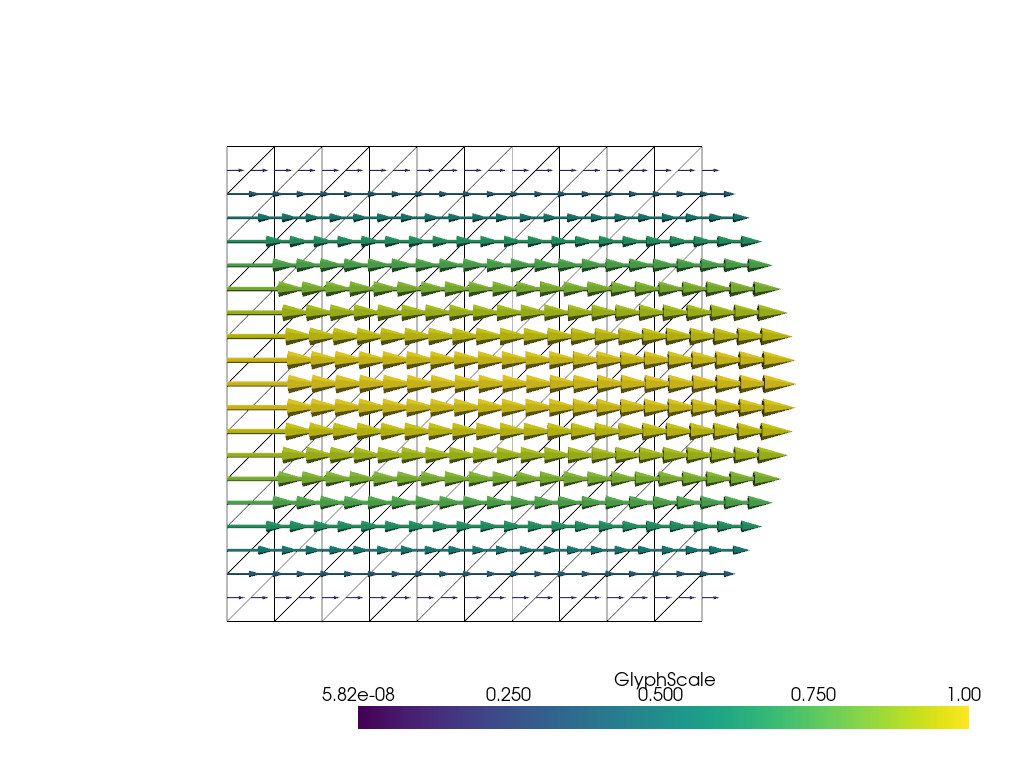

In [18]:
pyvista.start_xvfb()
topology, cell_types, geometry = vtk_mesh(V)
values = np.zeros((geometry.shape[0], 3), dtype=np.float64)
values[:, :len(u_n)] = u_n.x.array.real.reshape((geometry.shape[0], len(u_n)))

# Create a point cloud of glyphs
function_grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)
function_grid["u"] = values
glyphs = function_grid.glyph(orient="u", factor=0.2)

# Create a pyvista-grid for the mesh
grid = pyvista.UnstructuredGrid(*vtk_mesh(mesh, mesh.topology.dim))

# Create plotter
plotter = pyvista.Plotter()
plotter.add_mesh(grid, style="wireframe", color="k")
plotter.add_mesh(glyphs)
plotter.view_xy()
if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    fig_as_array = plotter.screenshot("glyphs.png")

## References
```{bibliography}
:filter: docname in docnames
```